# TP2 - Gaussian Mixture Model (GMM)


### ING5, BDA02
- ABUL KALAM Simon : [simon.abulkalam@edu.ece.fr](mailto:simon.abulkalam@edu.ece.fr)
- BARITEAU Yanis : [yanis.bariteau@edu.ece.fr](mailto:yanis.bariteau@edu.ece.fr)
- PUY Guillaume : [guillaume.puy@edu.ece.fr](mailto:guillaume.puy@edu.ece.fr)

# Libraries Importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# 1. Example (with Scikit-learn): Density estimation for a Gaussian mixture

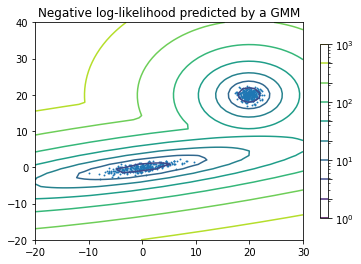

In [2]:
n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(X_train[:, 0], X_train[:, 1], .8)
plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


# 2. GMM from scratch

## 1. Initialization of Θ

In [3]:
# X : Given Variable
X = X_train

# I : Number of Samples
I = X_train.shape[0]

# N : Number of Features
N = X_train.shape[1]

# J : Number of Clusters
J = 2

# First Parameter
phi = np.array([1/J for _ in range(J)])

# Second Parameter
µ = np.random.uniform(-20., 30., size=(J, N))
µ = np.random.uniform(-20., 30., size=(J, N))

# Third Parameter
sigma = np.array([np.eye(N) for _ in range(J)])

In [4]:
print("\n#### X ####\n-----------")
print(X[:5])
print("\n#### Phi ####\n-------------")
print(phi)
print("\n###### µ ######\n---------------")
print(µ)
print("\n##### Sigma #####\n-----------------")
print(sigma)


#### X ####
-----------
[[21.76405235 20.40015721]
 [20.97873798 22.2408932 ]
 [21.86755799 19.02272212]
 [20.95008842 19.84864279]
 [19.89678115 20.4105985 ]]

#### Phi ####
-------------
[0.5 0.5]

###### µ ######
---------------
[[ 5.77976239 -1.69265974]
 [-1.43935117 -6.33083067]]

##### Sigma #####
-----------------
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


## 2. E-Step Calculation

In [5]:
def P_Xi_given_Zi_j(X, µ, sigma, i:int, j:int):
    N = X.shape[1]
    calcul = (1 / ( (2*np.pi)**(N/2) * np.sqrt(np.linalg.det(sigma[j])))) * np.exp( -0.5 * np.dot(np.transpose(X[i] - µ[j]), np.dot(np.linalg.inv(sigma[j]), (X[i] - µ[j]).reshape((len(X[i]),1))) ) )
    return calcul

def P_Zi_j(phi, j:int):
    return phi[j]

def P_Xi(X, phi, µ, sigma, i:int):
    N = X.shape[1]
    J = len(sigma)
    somme = 0

    for k in range(J):
        somme += (1 / ( (2*np.pi)**(N/2) * np.sqrt(np.linalg.det(sigma[k])) )) * np.exp( -0.5 * np.dot(np.transpose(X[i] - µ[k]), np.dot(np.linalg.inv(sigma[k]), (X[i] - µ[k]).reshape((len(X[i]),1))) ) ) * P_Zi_j(phi, k)
    return somme

def Wi_j(X, phi, µ, sigma, i:int, j:int):
    return P_Xi_given_Zi_j(X, µ, sigma, i, j)*P_Zi_j(phi, j) / P_Xi(X, phi, µ, sigma, i)

def E_Step(X, phi, µ, sigma):
    I = X.shape[0]
    N = X.shape[1]
    J = len(sigma)
    tmp1 = []

    for i in range(I):
        tmp2 = []
        for j in range(J):
            tmp2.append( Wi_j(X, phi, µ, sigma, i, j) )
        tmp1.append( tmp2 )

    W = np.asarray(tmp1)
    return W

## 3. M-Step Calculation

In [6]:
def M_Step(X, W):
    N = X.shape[1]
    I = X.shape[0]
    J = W.shape[1]

    phi = []
    µ = np.zeros(shape=(J, N))
    sigma = []

    for j in range(J):
        somme_wj = sum( W[i, j] for i in range(I) )

        phi.append( somme_wj / I )

        µ[j] = (1 / somme_wj) * ( sum( W[i, j] * X[i] for i in range(I) ) )

        sigma.append( (1 / somme_wj) * sum( W[i, j] * np.dot((X[i]-µ[j]).reshape((len(X[i]),1)), (X[i]-µ[j]).reshape((1, len(X[i])))) for i in range(I)) )

    return np.asarray(phi), np.asarray(µ), np.asarray(sigma)

# Loop for finding the best parameters

In [7]:
def plot_centroids(X_train, µ, i:int):
    x = np.linspace(-20., 30.)
    y = np.linspace(-20., 40.)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
    levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    plt.scatter(X_train[:, 0], X_train[:, 1], .8)
    plt.scatter(µ[0,0], µ[0,1], c='yellow')
    plt.scatter(µ[1,0], µ[1,1], c='orange')
    plt.title(f"Iteration N°{i}")
    plt.axis('tight')
    plt.show()

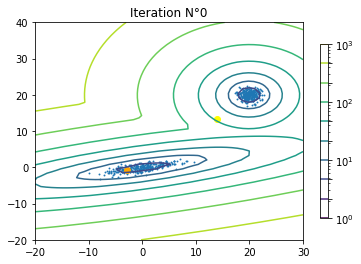

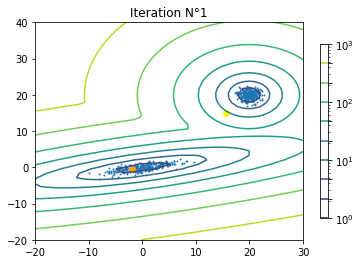

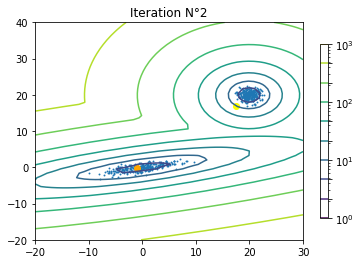

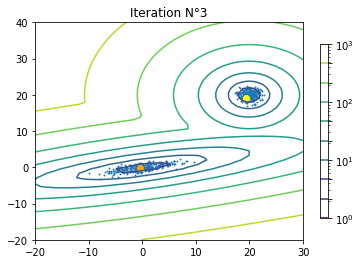

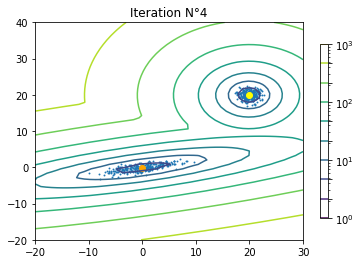

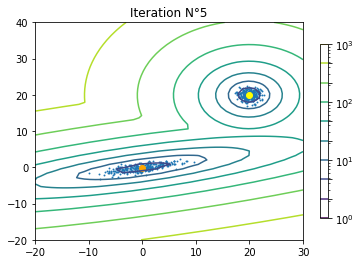

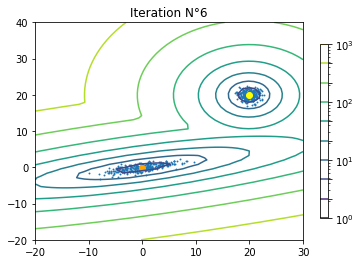

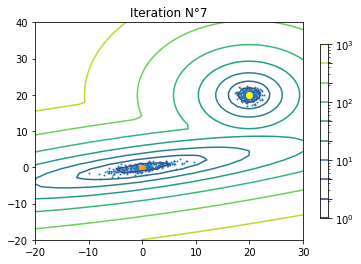

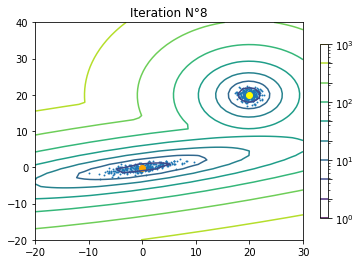

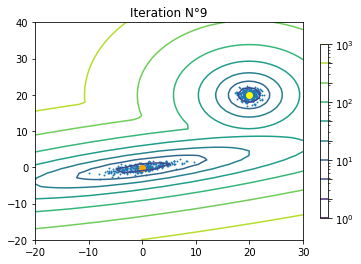


Phi's Shape : 2 | µ's Shape : (2, 2) | Sigma's Shape : (2, 2, 2)


#### Phi ####
-------------
[[0.5]
 [0.5]]

###### µ ######
---------------
[[19.91453549 19.97556345]
 [-0.13607006 -0.07059606]]

##### Sigma #####
-----------------
[[[1.02179864e+00 3.28158679e-03]
  [3.28158679e-03 9.90374215e-01]]

 [[1.13328030e+01 2.25048269e+00]
  [2.25048269e+00 8.77008968e-01]]]


In [8]:
for i in range(10):
    W = E_Step(X, phi, µ, sigma)
    phi, µ, sigma = M_Step(X, W)
    plot_centroids(X, µ, i)
    
print(f"\nPhi's Shape : {len(phi)} | µ's Shape : {µ.shape} | Sigma's Shape : {sigma.shape}\n")
print("\n#### Phi ####\n-------------")
print(phi)
print("\n###### µ ######\n---------------")
print(µ)
print("\n##### Sigma #####\n-----------------")
print(sigma)

# Discussion about our result

We apply the Gaussian Mixture algorithm. For this purpose, we have initialized, among other things, the values of `µ` randomly in the interval [-20, 30[. As a result, it is very rare that errors occur during the execution of the algorithm. As a result, it is impossible to find the ideal parameters because we get `NaN` values in the different parameters.

Unfortunately, we have not been able to fix this. For the time being, to overcome this, it is necessary to restart manually the program until the calculations do not encounter any problems.

However, when all works, the centroids are positioned in the centre of the two clusters. Furthermore, we have assumed that a loop of 10 iterations would be sufficient to find the ideal parameters (see graph).